In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import io
from google.colab import files
from numpy import argmax
from numpy import array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [ ]:
def clean_seq(filename):
    seq_df = pd.read_csv(filename, engine='python')
    sequences = seq_df['dna'].str.replace('[^ACGT]','N')
    for i in range(len(sequences)):
        sequences[i] = sequences[i].ljust(1058,'N')
    #print(sequences[0])
    
    sequences_array = np.array(sequences)
    #print(pd.DataFrame(sequences_array))
    seq_list_padded = []
    for i in range(len(sequences_array)):
        list_seq = list(sequences_array[i])
        del list_seq[650:]
        seq_list_padded.append(list_seq)
    print(len(list_seq))
    replace_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5}
    integer_encoded = []
    for i in range(len(seq_list_padded)):
        C = (pd.Series(seq_list_padded[i])).map(replace_map) #convert the list to a pandas series temporarily before mapping
        integer_encoded.append(list(C))
    data = np.array([1, 2, 3, 4, 5])
    data = data.reshape(-1, 1) 
    integer_encoded = np.array(integer_encoded).astype(int)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(data)
    one_hot_encoded_seqs = []
    for i in range(len(integer_encoded)):
        integer_encoded_tmp = integer_encoded[i].reshape(len(integer_encoded[i]), 1)
        onehot_encoded = np.array(onehot_encoder.transform(integer_encoded_tmp)).flatten()
        one_hot_encoded_seqs.append(onehot_encoded)
    one_hot_encoded_seqs_array = np.array(one_hot_encoded_seqs)
    print(one_hot_encoded_seqs_array.shape)
    #one_hot_encoded_seqs_array = one_hot_encoded_seqs_array.reshape(len(one_hot_encoded_seqs_array), 75, 50)
    #one_hot_encoded_seqs_array = np.expand_dims(one_hot_encoded_seqs_array, axis=3)
    
    return one_hot_encoded_seqs_array

def load_n_encode_labels(filename):
    df = pd.read_csv(filename)
    labels = df['labels']
    softmax_layer = len(set(labels))
    le = LabelEncoder()
    le.fit(labels)
    label_seq = le.transform(labels)
    label_seq = label_seq.reshape(len(label_seq), 1)
    
    return label_seq, le, softmax_layer

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

In [ ]:
uploaded = files.upload()

Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


KeyError: ignored

In [ ]:
filename_features = 'train_features.csv'
filename_labels = 'train_labels.csv'
one_hot_encoded_seqs_array = clean_seq(filename_features)
label_seq, le, softmax_layer = load_n_encode_labels(filename_labels)
X_train, X_validation, y_train, y_validation = train_test_split(one_hot_encoded_seqs_array, label_seq, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

650
(12906, 3250)
(10324, 3250)
(10324, 1)
(2582, 3250)
(2582, 1)


In [ ]:
num_epochs = 100
input_dim = X_train.shape[1]
print(input_dim)
# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel2_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

3250


In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_dim=input_dim),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(softmax_layer, activation='softmax')
])

In [ ]:
optimizer=optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
loss='sparse_categorical_crossentropy'
model2.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               325100    
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               25250     
_________________________________________________________________
batch_normalization_6 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)              

In [ ]:
history = model2.fit(X_train, y_train, batch_size=64, epochs=num_epochs, callbacks=callbacks, validation_data=(X_validation, y_validation), verbose=2)

Epoch 1/100
162/162 - 2s - loss: 5.9372 - accuracy: 0.1070 - val_loss: 5.2410 - val_accuracy: 0.1894

Epoch 00001: val_loss improved from inf to 5.24100, saving model to mymodel2_1
Epoch 2/100
162/162 - 1s - loss: 3.4423 - accuracy: 0.3876 - val_loss: 2.4960 - val_accuracy: 0.5201

Epoch 00002: val_loss improved from 5.24100 to 2.49603, saving model to mymodel2_2
Epoch 3/100
162/162 - 1s - loss: 2.0746 - accuracy: 0.6086 - val_loss: 1.1443 - val_accuracy: 0.7986

Epoch 00003: val_loss improved from 2.49603 to 1.14428, saving model to mymodel2_3
Epoch 4/100
162/162 - 1s - loss: 1.4427 - accuracy: 0.7198 - val_loss: 0.9653 - val_accuracy: 0.8304

Epoch 00004: val_loss improved from 1.14428 to 0.96531, saving model to mymodel2_4
Epoch 5/100
162/162 - 1s - loss: 1.1351 - accuracy: 0.7731 - val_loss: 1.0012 - val_accuracy: 0.8156

Epoch 00005: val_loss did not improve from 0.96531
Epoch 6/100
162/162 - 1s - loss: 0.9675 - accuracy: 0.7992 - val_loss: 0.7268 - val_accuracy: 0.8784

Epoch 000

In [ ]:
num_epochs = 100
input_dim = X_train.shape[1]
print(input_dim)
# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_dim=input_dim),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(softmax_layer, activation='softmax')
])

In [ ]:
optimizer=optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
loss='sparse_categorical_crossentropy'
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               325100    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               25250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1

In [ ]:
# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

history = model.fit(X_train, y_train, batch_size=64, epochs=num_epochs, callbacks=callbacks, validation_data=(X_validation, y_validation), verbose=2)

Epoch 1/100
162/162 - 7s - loss: 6.0584 - accuracy: 0.0979 - val_loss: 5.1905 - val_accuracy: 0.1208

Epoch 00001: val_loss improved from inf to 5.19050, saving model to mymodel_1
Epoch 2/100
162/162 - 2s - loss: 3.8440 - accuracy: 0.2875 - val_loss: 2.7835 - val_accuracy: 0.4345

Epoch 00002: val_loss improved from 5.19050 to 2.78348, saving model to mymodel_2
Epoch 3/100
162/162 - 2s - loss: 2.8580 - accuracy: 0.4187 - val_loss: 1.7034 - val_accuracy: 0.6491

Epoch 00003: val_loss improved from 2.78348 to 1.70337, saving model to mymodel_3
Epoch 4/100
162/162 - 2s - loss: 2.2730 - accuracy: 0.5188 - val_loss: 1.5442 - val_accuracy: 0.6828

Epoch 00004: val_loss improved from 1.70337 to 1.54416, saving model to mymodel_4
Epoch 5/100
162/162 - 2s - loss: 1.9359 - accuracy: 0.5588 - val_loss: 1.1537 - val_accuracy: 0.7878

Epoch 00005: val_loss improved from 1.54416 to 1.15372, saving model to mymodel_5
Epoch 6/100
162/162 - 2s - loss: 1.7106 - accuracy: 0.6148 - val_loss: 0.9655 - val_

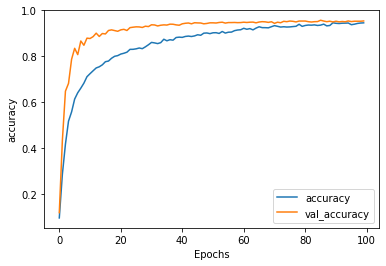

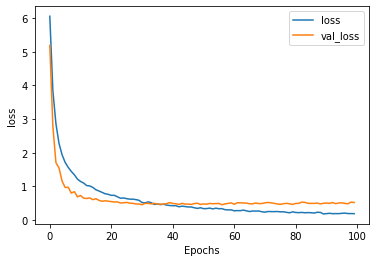

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model.load_weights("mymodel_23")

In [ ]:
print(model)

In [ ]:
#test_data_prediction and submission file creation
filename_features_test = 'test_features.csv'
one_hot_encoded_seqs_array_test = clean_seq(filename_features_test)

600
(8306, 3000)


In [ ]:
encoded_predict_labels = np.argmax(model.predict(one_hot_encoded_seqs_array_test), axis=1)
print(encoded_predict_labels)
test_predictions = decode_labels(encoded_predict_labels, le)
print(test_predictions)

[ 659    7  200 ...   55 1059  590]
[ 667    8  205 ...   59 1071  597]


In [ ]:
def get_seq_ids(filename):
    df = pd.read_csv(filename)
    ids = df['id']
    
    return np.array(ids)

test_ids = get_seq_ids(filename_features_test)
print(test_ids)

frames = [pd.DataFrame(test_ids), pd.DataFrame(test_seq_predictions)]
output_data= np.concatenate(frames, axis=1)
output_df = pd.DataFrame(output_data)
output_df.to_csv('dna_barcode_seq_submission3.csv', index=False,  header=["id","labels"])